In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import yaml


from random import uniform
from reconsnet.model.diffusion import DiffusionModule
from reconsnet.data.dataset import XRayDatasetRight, default_transform
from reconsnet.config import set_config_path, get_config
from reconsnet.util.camera import build_camera_model
from pathlib import Path
from tqdm import tqdm
from reconsnet.config import set_config_path
from reconsnet.data.postprocess import percentile_threshold, denoise_voxels
from pathlib import Path

CHECKPOINT_PATH = "../stronger-conditioning.ckpt"
RESULTS_PATH = "data/synthetic_right.csv"
CAMERA_GRID_SIZE = (60, 60, 60)
DATA_PATH = "/home/shared/imagecas/projections_split/val"

CONFIG_PATH=Path("../config")
with open(CONFIG_PATH / "projections.yaml") as f:
    CONFIG = yaml.SafeLoader(f.read()).get_data()

set_config_path(CONFIG_PATH)

In [25]:
def comparison_before_after(fig, voxel_tensor, voxel_tensor_before, voxel_tensor_more, gt, threshold=0.0, max_points=50000):
    vox = voxel_tensor.squeeze().detach().cpu().numpy()
    vox_before = voxel_tensor_before.squeeze().detach().cpu().numpy()
    vox_more = voxel_tensor_more.squeeze().detach().cpu().numpy()
    vox_gt = gt.squeeze().detach().cpu().numpy()
    
    coords = (vox > threshold).nonzero()
    coords_before = (vox_before > threshold).nonzero()
    coords_more = (vox_more > threshold).nonzero()
    coords_gt = (vox_gt > threshold).nonzero()
    
    x, y, z = coords[0], coords[1], coords[2]
    xb,yb,zb = coords_before[0], coords_before[1], coords_before[2]
    xm,ym,zm = coords_more[0], coords_more[1], coords_more[2]
    xgt,ygt,zgt = coords_gt[0], coords_gt[1], coords_gt[2]
    
    if len(x) > max_points:
        idx = torch.randperm(len(x))[:max_points]
        x, y, z = x[idx], y[idx], z[idx]
    
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xb, yb, zb, c='gray', s=1, alpha=0.2, label="P=2")
    ax.scatter(x, y, z, c='orange', s=1, alpha=0.4, label=f"P=3")
    ax.scatter(xm, ym, zm, c='crimson', s=1, alpha=0.6, label=f"P=4")
    ax.scatter(xgt, ygt, zgt, c='yellow', s=1, alpha=1, label=f"GT")
    ax.legend(loc="lower right")
    
    
def inject_extra_projection(projections, gt, inject_second=False):
    global_config = CONFIG['global']
    img_res = global_config['image_resolution']
    grid_res = global_config['grid_resolution']
    grid_spacing = uniform(*global_config["grid_spacing"]) 
    grid_dim = get_config()['data']['grid_dim']

    xray0 = projections[0]
    bp_before, gt_down, img0, img1 = default_transform(projections, gt)
    
    def perpendicular_bp(xray):
        alpha = -xray.beta
        beta = xray.alpha
        sid = xray.sid
        sod = xray.sod    
        img_spacing = xray.spacing
        camera = build_camera_model(alpha, beta, sid, sod, grid_spacing, grid_res, img_spacing, img_res)
        img = camera(gt)[0]
        bp = camera.adjoint(img).asarray()
              
        bp = (bp - bp.min()) / (bp.max() - bp.min() + 1e-8)
        bp = torch.from_numpy(bp).float().unsqueeze(0).unsqueeze(0)
        bp = F.interpolate(bp, size=(grid_dim, grid_dim, grid_dim), mode='trilinear', align_corners=False)
        return bp.squeeze(0)
     
    bp_after = torch.minimum(perpendicular_bp(xray0), bp_before)
    if inject_second:
        xray1 = projections[1]
        bp_after = torch.minimum(perpendicular_bp(xray1), bp_after)
    
    # comparison_before_after(bp_after, bp_before, bp_after2, gt_down)
    return bp_after, gt_down, img0, img1




In [3]:
model = DiffusionModule.load_from_checkpoint(CHECKPOINT_PATH, lr=1e-4)
reconstruct = lambda x: model.fast_reconstruct(*x, num_inference_steps=10, guidance=True)
ds_p2=XRayDatasetRight(root_dir=DATA_PATH)
ds_p3=XRayDatasetRight(root_dir=DATA_PATH, transform=inject_extra_projection)
ds_p4=XRayDatasetRight(root_dir=DATA_PATH, transform=lambda p, g: inject_extra_projection(p, g, True))

/home/dominik/3dreconsnet/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


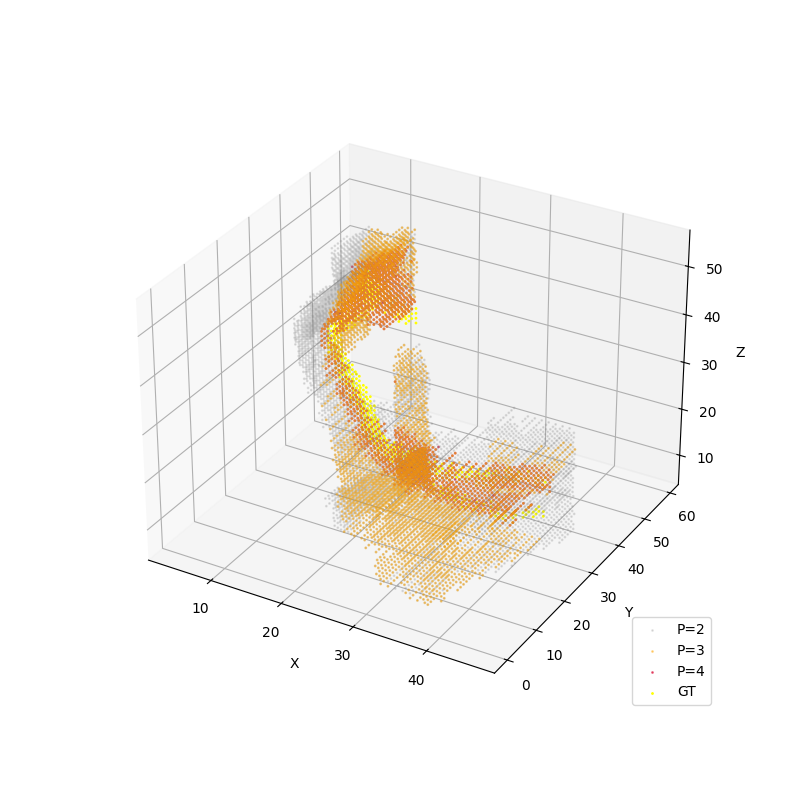

In [4]:
def recons_from_ds(ds, i):
    backprojection, _, p0, p1 = ds[i]
    backprojection = backprojection.to(model.device)
    p0 = p0.to(model.device)
    p1 = p1.to(model.device)
    hat = reconstruct((backprojection.unsqueeze(0), p0.unsqueeze(0), p1.unsqueeze(0)))
    hat = (hat - hat.min()) / (hat.max() - hat.min())

    threshold = percentile_threshold(hat, percentile=0.995)
    hat_bin = denoise_voxels((hat > threshold).float()).squeeze().cpu().numpy()
    return hat_bin.nonzero()

In [5]:
_, gt, _, _ = ds_p3[0]
coords_p2 = recons_from_ds(ds_p2, 0)
coords_p3 = recons_from_ds(ds_p3, 0)
coords_p4 = recons_from_ds(ds_p4, 0)

gt = gt.squeeze().detach().cpu().numpy()
gt = (gt > 0).nonzero()


/home/dominik/3dreconsnet/.venv/lib/python3.11/site-packages/odl/util/utility.py:1398: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_requirements
100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.75it/s]


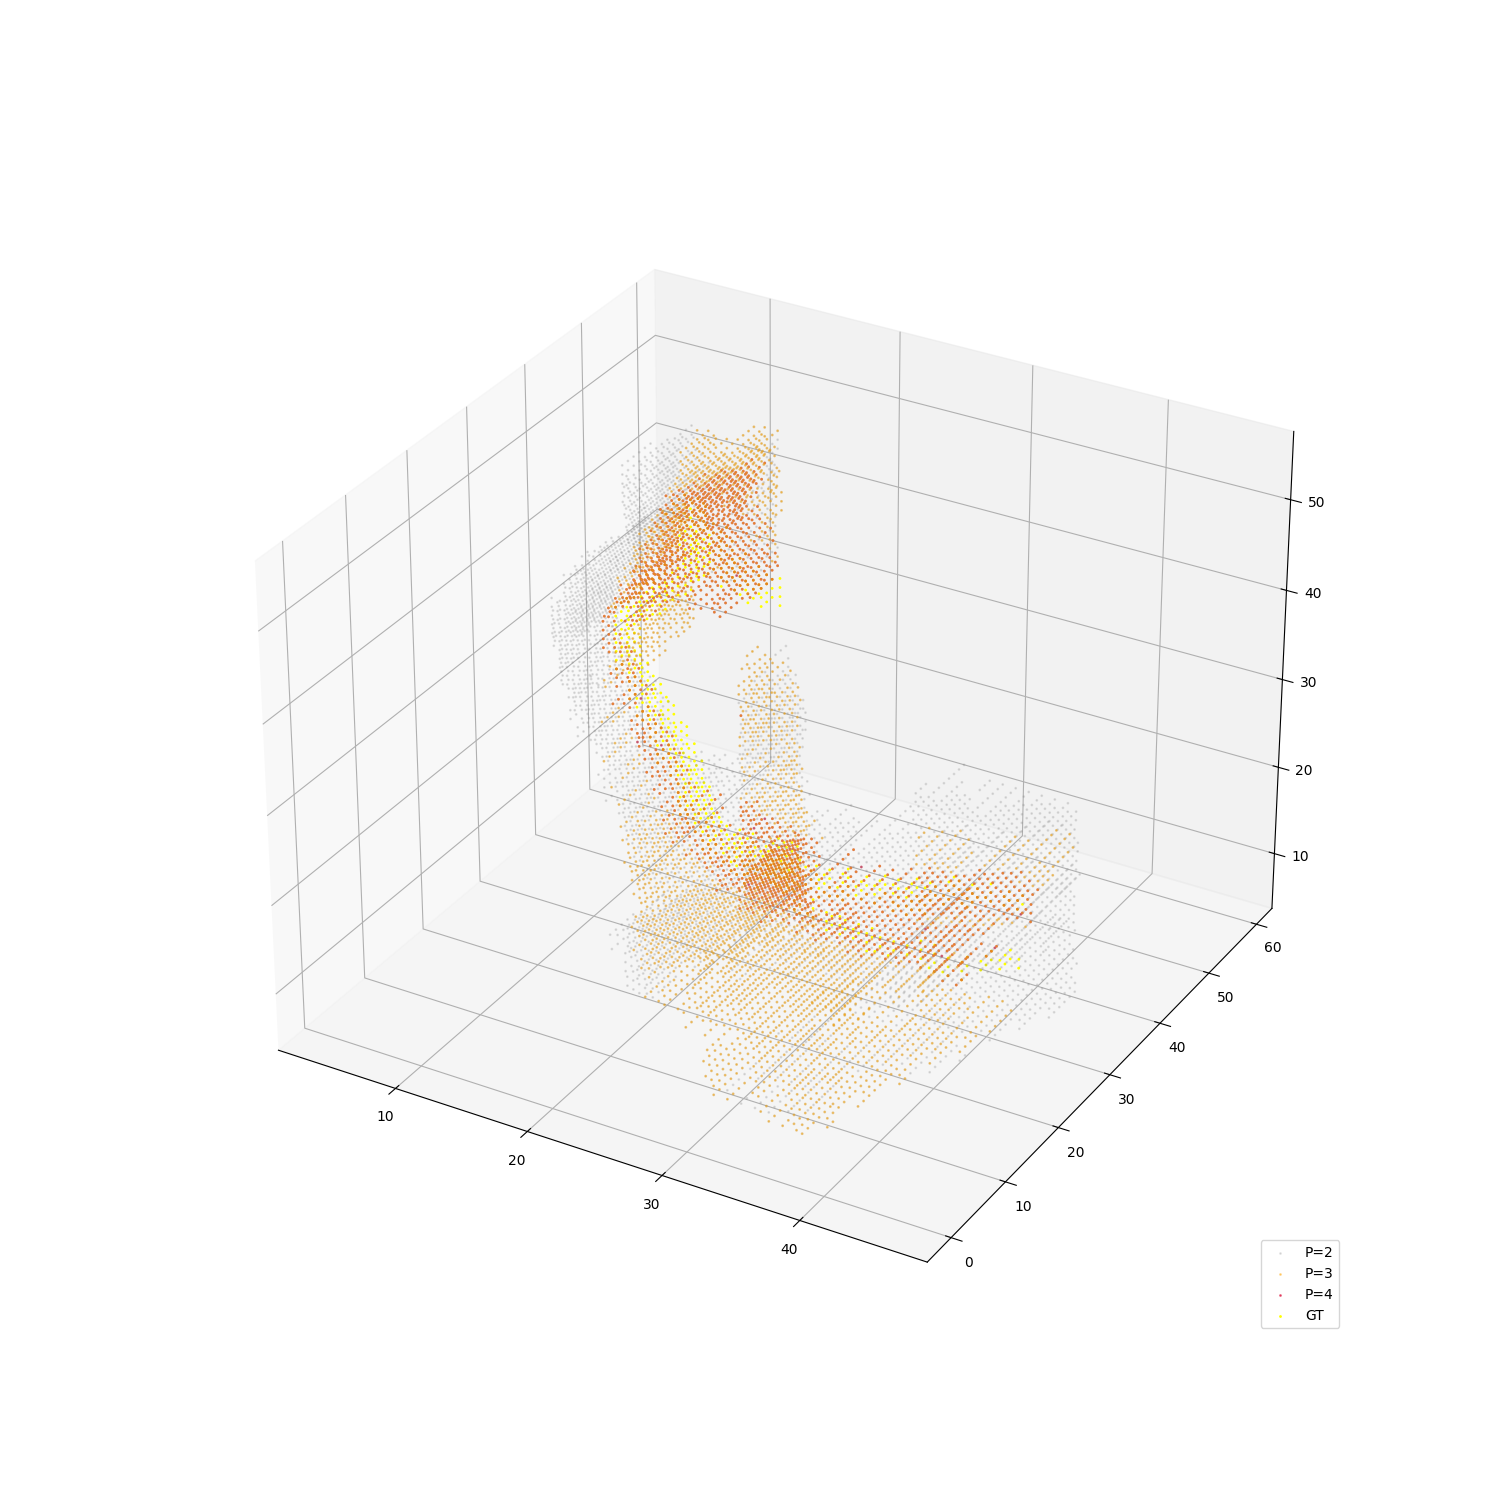

/tmp/ipykernel_1361562/1055202801.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15,15))


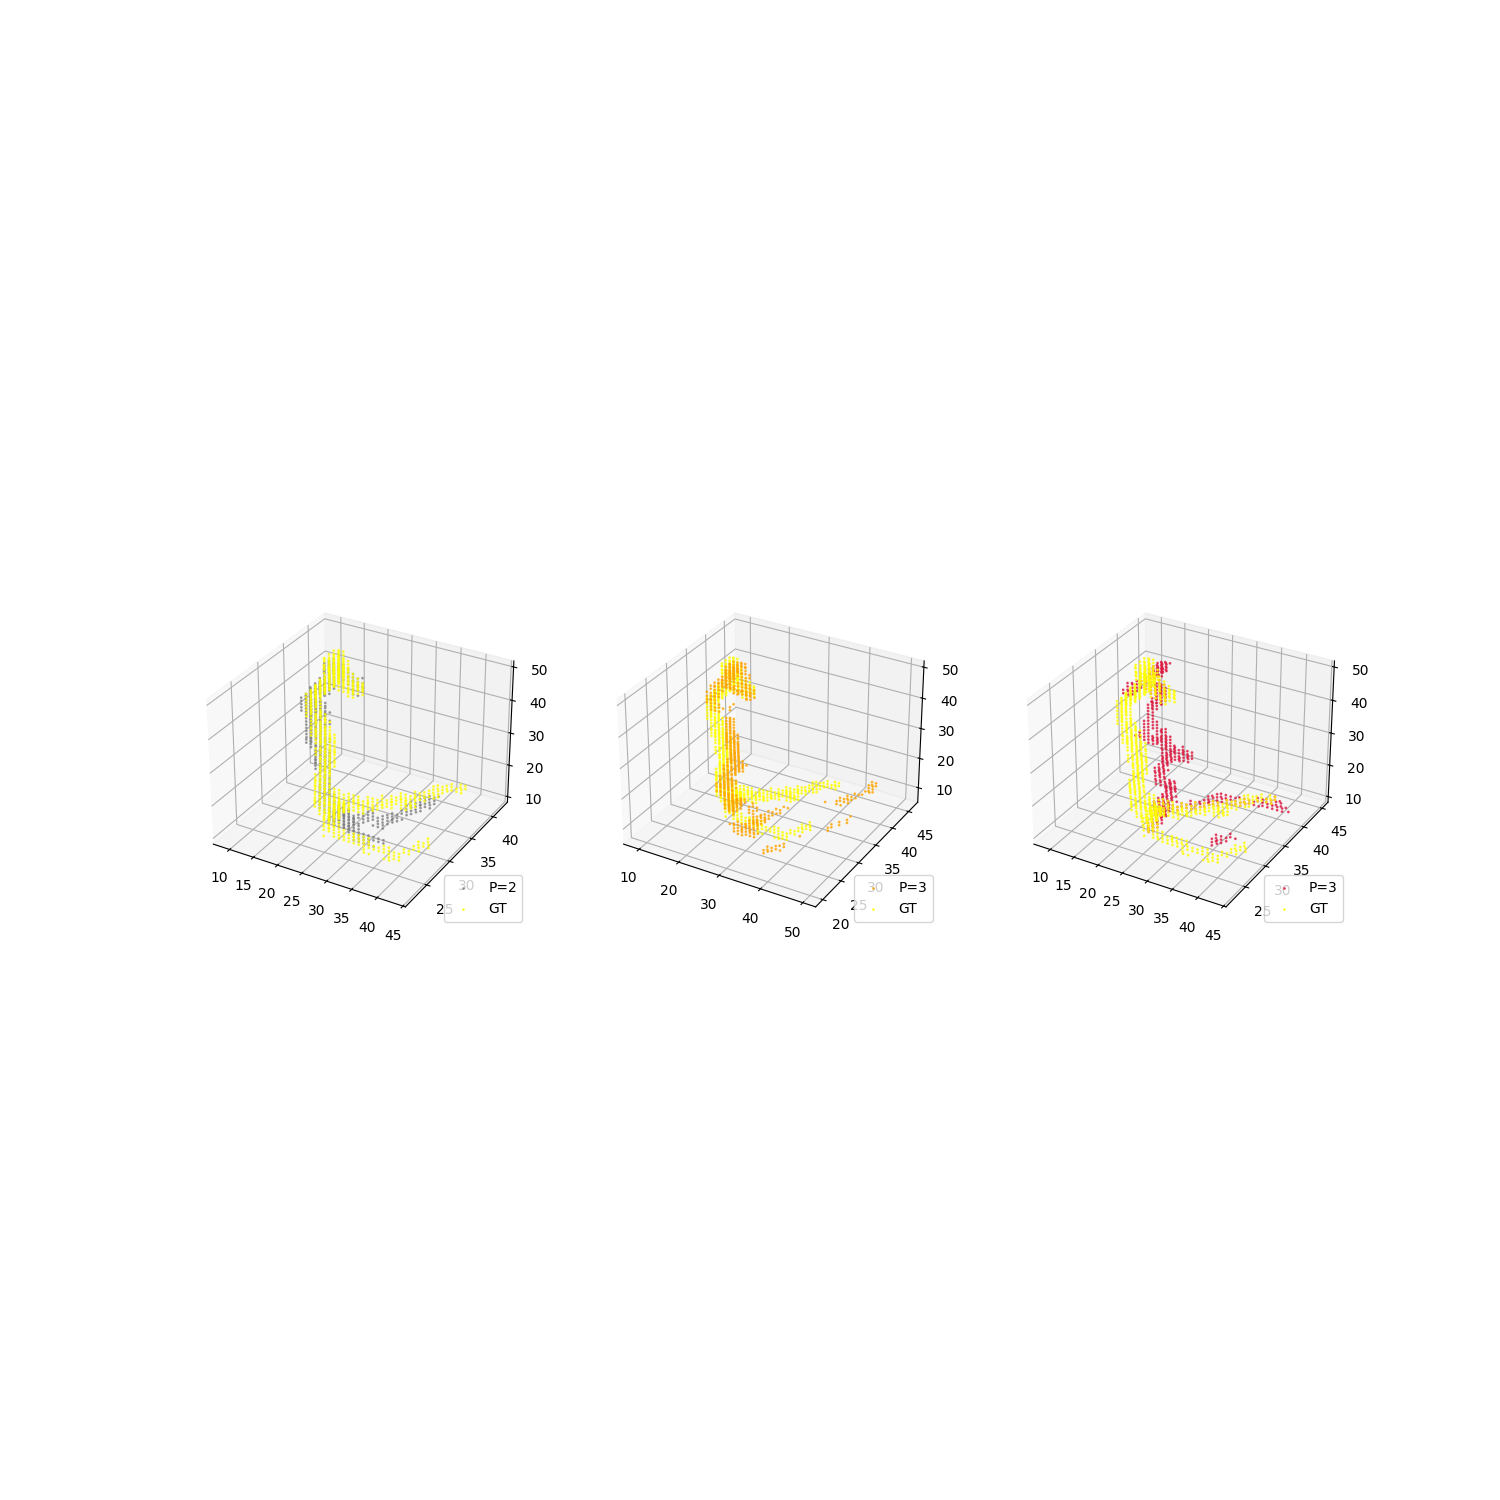

In [ ]:
%matplotlib ipympl


fig = plt.figure(figsize=(15,15))

comparison_before_after(fig, ds_p3[0][0], ds_p2[0][0], ds_p4[0][0], ds_p2[0][1])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(coords_p2[0], coords_p2[1], coords_p2[2], c='gray', s=1, alpha=0.7, label="P=2")
ax.scatter(gt[0], gt[1], gt[2], c='yellow', s=1, alpha=0.7, label="GT")
ax.legend(loc="lower right")
ax = fig.add_subplot(132, projection='3d')
ax.scatter(coords_p3[0], coords_p3[1], coords_p3[2], c='orange', s=1, alpha=0.7, label="P=3")
ax.scatter(gt[0], gt[1], gt[2], c='yellow', s=1, alpha=0.7, label="GT")
ax.legend(loc="lower right")
ax = fig.add_subplot(133, projection='3d')
ax.scatter(coords_p4[0], coords_p4[1], coords_p4[2], c='crimson', s=1, alpha=0.7, label="P=4")
ax.scatter(gt[0], gt[1], gt[2], c='yellow', s=1, alpha=0.7, label="GT")
ax.legend(loc="lower right")
plt.show()

